In [12]:
import logging

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import ConnectionPatch
from numba import njit, prange
from scipy.optimize import curve_fit
from scipy.sparse.csgraph import laplacian

from graph_optimization import (fastest_averaging_constant_weight,
                                fdla_weights_symmetric, fmmc_weights,
                                lmsc_weights, max_degree_weights,
                                metropolis_hastings_weights)

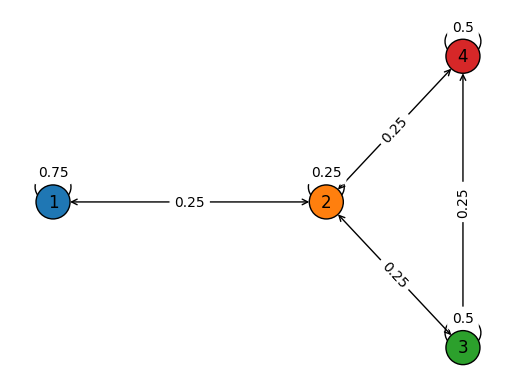

In [13]:
num_arms = 4
adj = np.load('data/saved_networks/tadpole_adj.npy')
inc = np.load('data/saved_networks/tadpole_inc.npy')
num_agents = adj.shape[0]
num_runs = 10000
num_steps = 1000
bandits = np.random.normal(0, 1, (num_runs, num_arms))
# _, P, _ = fmmc_weights(inc)
P = np.array([
	[0.75, 0.25, 0.00, 0.00],
	[0.25, 0.25, 0.25, 0.25],
	[0.00, 0.25, 0.50, 0.25],
	[0.00, 0.25, 0.25, 0.50],
])
competencies = np.array([0.5, 1.0, 1.0, 1.0])

fig, ax = plt.subplots()

G = nx.from_numpy_array(P)
node_labels = {i: i + 1 for i in range(num_agents)}
edge_labels = nx.get_edge_attributes(G, 'weight')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
pos = nx.spectral_layout(G)
# nx.draw(G, pos, node_color=colors, with_labels=True)
nx.draw_networkx_nodes(G, pos, edgecolors='#000000', node_color=colors, node_size=600, linewidths=1)
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw_networkx_edges(G, pos, edgelist=edge_labels.keys(), width=1, arrows=True, node_size=600, arrowstyle='<->')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis('off')
plt.savefig('data/img/pdf/tadpole_manual.pdf', bbox_inches='tight')
plt.show()

In [14]:
print(adj)
my_p = np.eye(adj.shape[0]) - (1/4) * laplacian(adj, normed=False)
print(my_p)

[[0 1 0 0]
 [1 0 1 1]
 [0 1 0 1]
 [0 1 1 0]]
[[0.75 0.25 0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.25 0.5  0.25]
 [0.   0.25 0.25 0.5 ]]


In [15]:
@njit(parallel=True)
def run1(runs: int, N: int, T: int, trueMeans: np.ndarray, P: np.ndarray, competencies: np.ndarray, mode: int) -> tuple:
	'''
	Plays coopucb2 given the number of runs, number of arms, timesteps, true
	means of arms, and the P matrix of the network. Optimized to work with
	numba.
	'''
	sigma_g = 1		# try 10
	eta = 2		# try 2, 2.2, 3.2
	gamma = 2.0 	# try 1.9, 2.9
	f = lambda t : np.sqrt(np.log(t))
	var = 1		# variance for the gaussian distribution behind each arm
	M, _ = P.shape
	# get the agent with the highest degree
	degrees = np.array([np.count_nonzero(row) for row in P])
	max_degree_agent = np.argmin(degrees)

	G_eta = 1 - (eta ** 2) / 16
	c0 = 2 * gamma / G_eta

	reg = np.zeros((runs, M, T))
	snerr = np.zeros((runs, M, T))

	times_best_arm_selected = np.zeros((runs, M), dtype=np.int16)
	percent_optimal_action = np.zeros((runs, M, T))

	# run coop-ucb2 "runs" number of times
	for run in prange(runs):
		Q = np.zeros((M, N))	# estimated reward
		n = np.zeros((M, N))	# number of times an arm has been selected by each agent
		s = np.zeros((M, N))	# cumulative expected reward
		xsi = np.zeros((M, N))	# number of times that arm has been selected in that timestep
		rew = np.zeros((M, N))	# reward
		best_arm = np.max(trueMeans[run])
		best_arm_idx = np.argmax(trueMeans[run])

		for t in range(T):
			_t = t - 1 if t > 0 else 0
			if t < N:
				for k in range(M):
					rew[k] = np.zeros(N)
					xsi[k] = np.zeros(N)
					action = t

					# rew[k, action] = np.random.normal(trueMeans[run, action], var)
					
					if mode == 0:
						# perfect agents
						rew[k, action] = np.random.normal(trueMeans[run, action], var)
					elif mode == 1:
						# first iteration of competency formula
						rew[k, action] = np.random.normal(
							trueMeans[run, action] * competencies[k],
							var / competencies[k]
						)
					else:
						# second iteration of competency formula
						rew[k, action] = np.random.normal(
							trueMeans[run, action] * (competencies[k] + np.random.randn()),
							var / (competencies[k] * np.abs(np.random.randn()))
						) if competencies[k] < 1 else np.random.normal(trueMeans[run, action], var / competencies[k])
					reg[run, k, t] = best_arm - trueMeans[run, action]
					xsi[k, action] += 1
					if action == best_arm_idx:
						times_best_arm_selected[run, k] += 1
			else:
				for k in range(M):
					for i in range(N):
						# Q[k, i, t] = (s[k, i] / n[k, i]) + sigma_g * (np.sqrt((2 * gamma / Geta) * ((n[k, i] + f(t - 1)) / (M * n[k, i])) * (np.log(t - 1) / n[k, i])))
						x0 = s[k, i] / n[k, i]
						# x1 = 2 * gamma / Geta
						c1 = (n[k, i] + f(_t)) / (M * n[k, i])
						c2 = np.log(_t) / n[k, i]
						confidence_bound = sigma_g * np.sqrt(c0 * c1 * c2)
						Q[k, i] = x0 + confidence_bound

					rew[k] = np.zeros(N)
					xsi[k] = np.zeros(N)

					action = np.argmax(Q[k, :])

					if mode == 0:
						# perfect agents
						rew[k, action] = np.random.normal(trueMeans[run, action], var)
					elif mode == 1:
						# first iteration of competency formula
						rew[k, action] = np.random.normal(
							trueMeans[run, action] * competencies[k],
							var / competencies[k]
						)
					else:
						# second iteration of competency formula
						rew[k, action] = np.random.normal(
							trueMeans[run, action] * (competencies[k] + np.random.randn()),
							var / (competencies[k] * np.abs(np.random.randn()))
						) if competencies[k] < 1 else np.random.normal(trueMeans[run, action], var / competencies[k])
					reg[run, k, t] = best_arm - trueMeans[run, action]
					xsi[k, action] += 1

					snerr[run, k, t] = np.abs(trueMeans[run, best_arm_idx] - (s[k, best_arm_idx] / n[k, best_arm_idx]))

					if action == best_arm_idx:
						times_best_arm_selected[run, k] += 1

			percent_optimal_action[run, :, t] = times_best_arm_selected[run, :] / (t + 1)

			# update estimates using running consensus
			for i in range(N):
				n[:, i] = P @ (n[:, i] + xsi[:, i])
				s[:, i] = P @ (s[:, i] + rew[:, i])

	return reg, snerr, percent_optimal_action

In [16]:
# _, _, percent_perfect = coopucb2_og(bandits, np.array([0]), competencies, num_steps, P)
# _, _, percent_iter1   = coopucb2_og(bandits, np.array([0]), competencies, num_steps, P)
# _, _, percent_iter2   = coopucb2_og(bandits, np.array([0]), competencies, num_steps, P)

regret_perfect, snerr_perfect, percent_perfect = run1(num_runs, num_agents, num_steps, bandits, P, competencies, 0)
regret_iter1,   snerr_iter1, percent_iter1   = run1(num_runs, num_agents, num_steps, bandits, P, competencies, 1)
regret_iter2,   snerr_iter2, percent_iter2   = run1(num_runs, num_agents, num_steps, bandits, P, competencies, 2)

In [17]:
percent_perfect = np.mean(percent_perfect, axis=0)
percent_iter1   = np.mean(percent_iter1, axis=0)
percent_iter2   = np.mean(percent_iter2, axis=0)

regret_perfect = np.mean(np.cumsum(regret_perfect, axis=2), axis=0)
regret_iter1   = np.mean(np.cumsum(regret_iter1, axis=2), axis=0)
regret_iter2   = np.mean(np.cumsum(regret_iter2, axis=2), axis=0)

snerr_perfect = np.mean(snerr_perfect, axis=0)
snerr_iter1   = np.mean(snerr_iter1, axis=0)
snerr_iter2   = np.mean(snerr_iter2, axis=0)

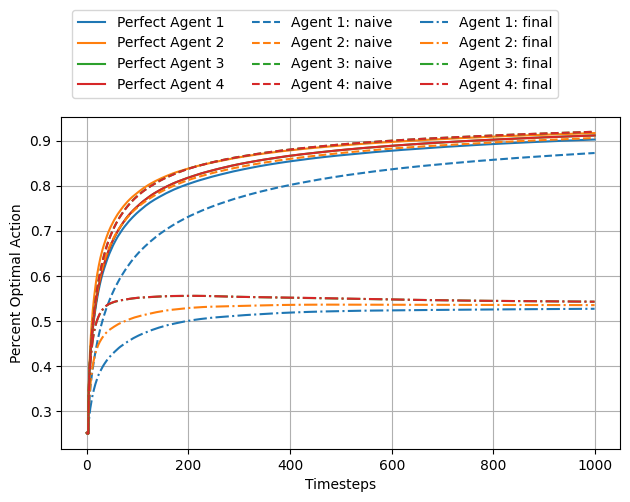

In [22]:
%matplotlib inline

fig = plt.figure()
plot_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(num_agents):
	plt.plot(percent_perfect[i], label=f'Perfect Agent {i + 1}', linestyle='-', color=plot_colors[i])
for i in range(num_agents):
	plt.plot(percent_iter1[i], label=f'Agent {i + 1}: naive', linestyle='--', color=plot_colors[i])
for i in range(num_agents):
	plt.plot(percent_iter2[i], label=f'Agent {i + 1}: final', linestyle='-.', color=plot_colors[i])
plt.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', bbox_transform=fig.transFigure, ncols=3)
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Percent Optimal Action')
plt.tight_layout()
plt.savefig('data/img/pdf/tadpole_percent_optimal_competency_comparison.pdf', bbox_inches='tight')
plt.show()

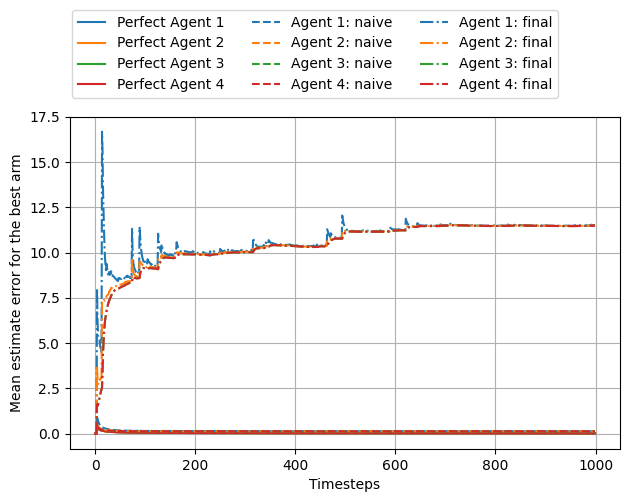

In [21]:
%matplotlib inline

fig = plt.figure()
plot_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(num_agents):
	plt.plot(snerr_perfect[i], label=f'Perfect Agent {i + 1}', linestyle='-', color=plot_colors[i])
for i in range(num_agents):
	plt.plot(snerr_iter1[i], label=f'Agent {i + 1}: naive', linestyle='--', color=plot_colors[i])
for i in range(num_agents):
	plt.plot(snerr_iter2[i], label=f'Agent {i + 1}: final', linestyle='-.', color=plot_colors[i])
plt.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', bbox_transform=fig.transFigure, ncols=3)
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Mean estimate error for the best arm')
plt.tight_layout()
plt.savefig('data/img/pdf/tadpole_snerr_competency_comparison.pdf', bbox_inches='tight')
plt.show()